In [79]:
# Para visuzalización en notebook
from IPython.display import Audio
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['font.size'] = 22

# Números y Datos
import numpy as np
import pandas as pd
# from scipy.spatial import distance_matrix
from scipy.spatial.distance import pdist, squareform

# Análisis de sonido
import librosa
import librosa.display
import spotipy 
from spotipy.oauth2 import SpotifyClientCredentials 

# Bajar cosas de internet
import urllib.request

# Machine learning
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
from sklearn.metrics import adjusted_rand_score, silhouette_score, silhouette_samples
from sklearn.decomposition import PCA
from IPython.display import Audio, Markdown, Image

def dmd(x):
    display(Markdown(x))
    
mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['font.size'] = 22

# Procesamiento de audio

## Archivo de sonido

Un archivo de sonido tiene una frecuencia de muestreo que indica cuantas muestras tiene en un segundo.
Al abrir un archivo de sonido obtenemos un array conteniendo las muestras y la frecuencia de muestreo

In [5]:
audio, frecuencia_muestreo = librosa.load('data/SopSax.NoVib.mf.C4B4.wav', sr=None, offset=0.8, duration=3.5) # podemos cargar solo un segmento especificando inicio (offset) y duración 
dmd('### Dimensiones del array')
display(audio.shape)

dmd('### Frecuencia de muestreo')
display(frecuencia_muestreo)

### Dimensiones del array

(154350,)

### Frecuencia de muestreo

44100

Para graficar la forma de onda generamos un array con los tiempos de cada muestra

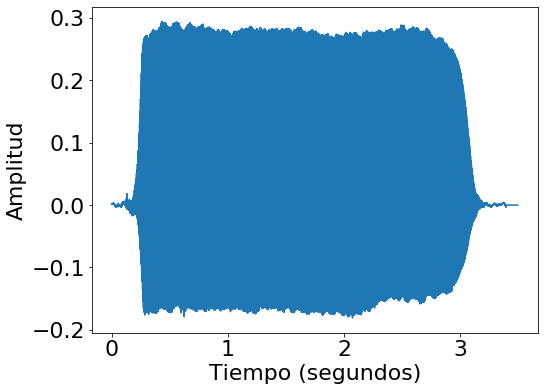

In [6]:
t = librosa.samples_to_time(np.arange(audio.size),frecuencia_muestreo)
plt.plot(t,audio)
plt.xlabel('Tiempo (segundos)')
plt.ylabel('Amplitud');
Audio(audio,rate=frecuencia_muestreo) # permite escuchar en el browser

In [7]:
# Así se escribe una sinusoide de 440 hertz
# audio = np.sin(2*np.pi*440*t)

## Análisis espectral

Para computar el espectro de una señal con valores reales, utilizamos la función rfft. Para calcular la potencia por frecuencia en decibeles se normaliza el resultado de rfft y se computa 10*log10 del módulo del espectro al cuadrado.

$$ \displaystyle P_{db} = 10 log_{10}(2|rfft(x)|^2/N) $$

### Dimensiones de RFFT

(77176,)

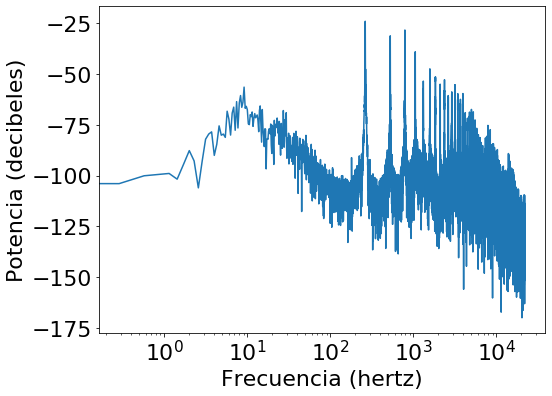

In [8]:
espectro = 10*np.log10(np.abs(2*np.fft.rfft(audio)/audio.size)**2)

dmd('### Dimensiones de RFFT')
display(espectro.shape)

frecuencias = librosa.fft_frequencies(sr=frecuencia_muestreo, n_fft=audio.size)

plt.semilogx(frecuencias, espectro)
# plt.ylim(-10,1)
plt.xlabel('Frecuencia (hertz)')
plt.ylabel('Potencia (decibeles)');

Para computar un espectrograma utilizamos la función stft (con los parámetros de tamaño de ventana y salto por defecto). La pasamos a decibeles con la funcion amplitude_to_db y la graficamos con specshow

### Dimensiones de STFT

(1025, 302)

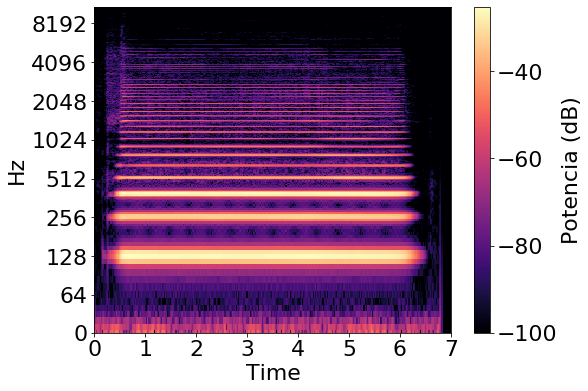

In [9]:
plt.figure()
tamaño_ventana = 2048
espectrograma = librosa.amplitude_to_db(np.abs(2*librosa.stft(audio,n_fft=tamaño_ventana)/tamaño_ventana ))

dmd('### Dimensiones de STFT')
display(espectrograma.shape)

librosa.display.specshow(espectrograma, x_axis='time', y_axis='log')
plt.colorbar(label='Potencia (dB)');

## Filtrado espectral

La stft es invertible y se puede recuperar el sonido con la istft (inversa). Se puede filtrar porciones del espectrograma modificando los valores del array

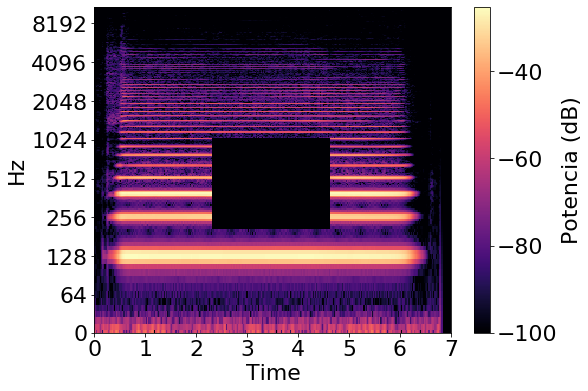

In [10]:
stft = librosa.stft(audio,n_fft=tamaño_ventana, hop_length=tamaño_ventana//4)

stft[20:100,100:200] = 0

espectrograma = librosa.amplitude_to_db(np.abs(2*stft/tamaño_ventana ))

librosa.display.specshow(espectrograma, x_axis='time', y_axis='log')
plt.colorbar(label='Potencia (dB)');

audio_filtrado = librosa.istft(stft,hop_length=tamaño_ventana//4)
Audio(audio_filtrado,rate=frecuencia_muestreo)

In [11]:
# Borrar todo pero conservar un sólo armónico
# stft = librosa.stft(audio,n_fft=tamaño_ventana, hop_length=tamaño_ventana//4)
# mascara = np.ones_like(stft,dtype=np.bool)
# mascara[22:28,:] = False
# stft[mascara] = 0
# espectrograma = librosa.amplitude_to_db(np.abs(2*stft/tamaño_ventana ))
# librosa.display.specshow(espectrograma, x_axis='time', y_axis='log')
# plt.colorbar(label='Potencia (dB)');
# audio_filtrado = librosa.istft(stft,hop_length=tamaño_ventana//4)
# Audio(audio_filtrado,rate=frecuencia_muestreo)

# Spotify API

Para conectarse a la API debemos ingresar las credenciales. Para coneseguirlas entrar a [https://developer.spotify.com/dashboard](https://developer.spotify.com/dashboard), logearse y crear el Client ID. Poner un nombre y descripción arbitrarios a la App y poner sin usos comerciales. Luego copiar las clave de id y secreta del cliente

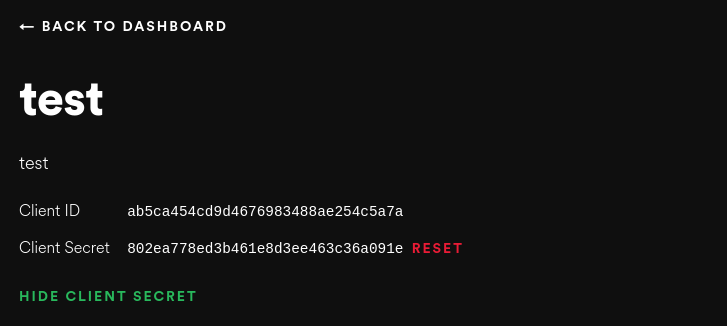

In [12]:
SPOTIFY_CLIENT_ID = 'ab5ca454cd9d4676983488ae254c5a7a'
SPOTIFY_CLIENT_SECRET = '802ea778ed3b461e8d3ee463c36a091e'

In [13]:
sp = spotipy.Spotify() 
client_credentials_manager = SpotifyClientCredentials(client_id=SPOTIFY_CLIENT_ID, client_secret=SPOTIFY_CLIENT_SECRET) 
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager) 
sp.trace=False

## Funciones de la API

Documentación de la API de spotify
[https://developer.spotify.com/documentation/](https://developer.spotify.com/documentation/)

In [14]:
for function in [sp.search, sp.artist, sp.album, sp.tracks, sp.audio_analysis, sp.audio_features]:
    dmd('#### sp.{}():\n{}'.format(function.__name__, function.__doc__.split('\n')[0]))

#### sp.search():
 searches for an item

#### sp.artist():
 returns a single artist given the artist's ID, URI or URL

#### sp.album():
 returns a single album given the album's ID, URIs or URL

#### sp.tracks():
 returns a list of tracks given a list of track IDs, URIs, or URLs

#### sp.audio_analysis():
 Get audio analysis for a track based upon its Spotify ID

#### sp.audio_features():
 Get audio features for one or multiple tracks based upon their Spotify IDs

## Busqueda por artista

### sp.search

Hacemos la búsqueda "the beatles" y vemos los resultados

In [26]:
the_beatles_search = sp.search('the beatles',type='artist')
[item['name'] for item in the_beatles_search['artists']['items']]

['The Beatles',
 'The Tape-beatles',
 'The Norwegian Beatles',
 'Olipa kerran The Beatles',
 'Better Than The Beatles',
 'the beatles featuring mark pearson',
 'The Beatles Recovered Band',
 'The Beatles Tribute Band',
 'The Beatles Tribute Project',
 'The Beatles Greatest Hits Performed By The Frank Berman Band']

Hasta podemos ver imágenes de los artistas

In [17]:
Image(url= the_beatles_search['artists']['items'][0]['images'][2]['url'])

Busquemos los tracks principales del artista seleccionado

### sp.artist_top_tracks

In [18]:
the_beatles_id = the_beatles_search['artists']['items'][0]['id']
the_beatles_top_tracks = sp.artist_top_tracks(the_beatles_id)
[item['name'] for item in the_beatles_top_tracks['tracks']]

['Here Comes The Sun - Remastered 2009',
 'Let It Be - Remastered 2009',
 'Hey Jude - Remastered 2015',
 'Come Together - Remastered 2009',
 'Yesterday - Remastered 2009',
 'I Want To Hold Your Hand - Remastered 2015',
 'Twist And Shout - Remastered 2009',
 'In My Life - Remastered 2009',
 'Help! - Remastered 2009',
 'Blackbird - Remastered 2009']

Veamos la información que obtenemos de un track

In [32]:
pd.DataFrame([the_beatles_top_tracks['tracks'][3]]).T

,0
album,"{'album_type': 'album', 'artists': [{'external..."
artists,[{'external_urls': {'spotify': 'https://open.s...
disc_number,1
duration_ms,259946
explicit,False
external_ids,{'isrc': 'GBAYE0601690'}
external_urls,{'spotify': 'https://open.spotify.com/track/2E...
href,https://api.spotify.com/v1/tracks/2EqlS6tkEngl...
id,2EqlS6tkEnglzr7tkKAAYD
is_local,False


# Descriptores y análisis del audio


Para pedir audio_features y audio_analysis debemos usar el track_id.

### sp.audio_features

audio_features contiene features de alto nivel, como cuán bailable o acústico es el audio, su valencia emocional, tempo, etc

In [35]:
# tomamos el track_id del 4to top track de los beatles
track_id = the_beatles_top_tracks['tracks'][3]['id']

audio_features = sp.audio_features(track_id)
pd.DataFrame(audio_features).T

,0
acousticness,0.0302
analysis_url,https://api.spotify.com/v1/audio-analysis/2Eql...
danceability,0.533
duration_ms,259947
energy,0.376
id,2EqlS6tkEnglzr7tkKAAYD
instrumentalness,0.248
key,9
liveness,0.0926
loudness,-11.913


### sp.audio_analysis

Los resultados de audio_analysis contienen descriptores de más bajo nivel divididos por segmentos de audio y más cosas.

In [36]:
audio_analysis = sp.audio_analysis(track_id)

Podemos ver la información por cada segmento

In [23]:
segments = pd.DataFrame(audio_analysis['segments'])
segments

,confidence,duration,loudness_end,loudness_max,loudness_max_time,loudness_start,pitches,start,timbre
0,0.000,1.00295,NaN,-60.000,0.00000,-60.000,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.00000,"[0.0, 171.13, 9.469, -28.48, 57.491, -50.067, ..."
1,1.000,0.35197,NaN,-8.329,0.14114,-60.000,"[0.469, 0.664, 1.0, 0.555, 0.238, 0.1, 0.152, ...",1.00295,"[34.236, 181.432, -51.845, -147.112, -36.499, ..."
2,0.311,0.08299,NaN,-18.589,0.00743,-27.067,"[0.621, 1.0, 0.811, 0.797, 0.259, 0.261, 0.076...",1.35492,"[35.487, 10.762, -118.892, -15.933, -38.73, -9..."
3,1.000,0.23424,NaN,-9.653,0.05398,-27.939,"[0.075, 0.68, 1.0, 0.275, 0.116, 0.063, 0.022,...",1.43791,"[40.541, 51.942, -83.987, -54.065, -25.656, 64..."
4,0.433,0.13673,NaN,-17.113,0.03145,-25.359,"[0.333, 1.0, 0.202, 0.025, 0.006, 0.007, 0.009...",1.67215,"[37.301, 35.653, -118.489, -28.661, -39.881, -..."
5,0.318,0.15465,NaN,-20.825,0.00006,-26.610,"[0.308, 1.0, 0.755, 0.13, 0.104, 0.316, 0.244,...",1.80889,"[37.33, 15.416, -116.987, -89.416, -27.551, -6..."
6,0.044,0.10136,NaN,-19.930,0.00983,-23.802,"[0.254, 1.0, 0.977, 0.46, 0.204, 0.045, 0.513,...",1.96354,"[37.886, 10.214, -135.926, -73.926, -6.857, -6..."
7,0.333,0.11365,NaN,-19.718,0.00978,-24.650,"[0.206, 0.822, 1.0, 0.351, 0.239, 0.069, 0.126...",2.06490,"[38.126, 46.576, -151.427, -57.257, 8.604, -59..."
8,0.809,0.36730,NaN,-14.336,0.02566,-25.686,"[0.026, 0.036, 0.212, 0.022, 0.019, 1.0, 0.067...",2.17855,"[39.846, 40.195, -162.686, 40.987, 2.464, -37...."
9,0.128,0.20512,NaN,-24.965,0.02104,-28.971,"[0.104, 0.374, 0.165, 0.089, 0.125, 1.0, 0.187...",2.54585,"[31.867, -134.312, -114.132, -55.329, -6.838, ..."


Seleccionamos los descriptores tímbricos y lo visualizacmos como un heatmap

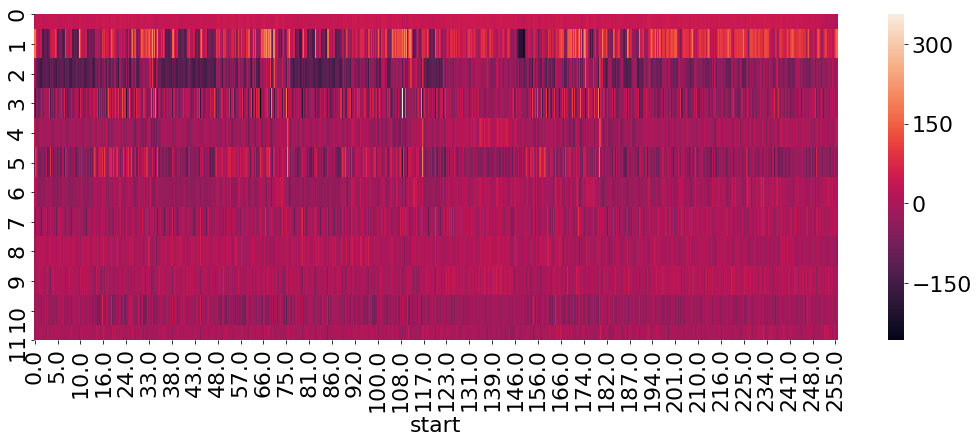

In [24]:
timbre = pd.DataFrame(np.vstack(segments.timbre), index=segments.start.round())
plt.figure(figsize=(18,6))
sns.heatmap(timbre.T);

Esto es la información que brinda Spotify sobre lo que representan sus 12 valores tímbricos

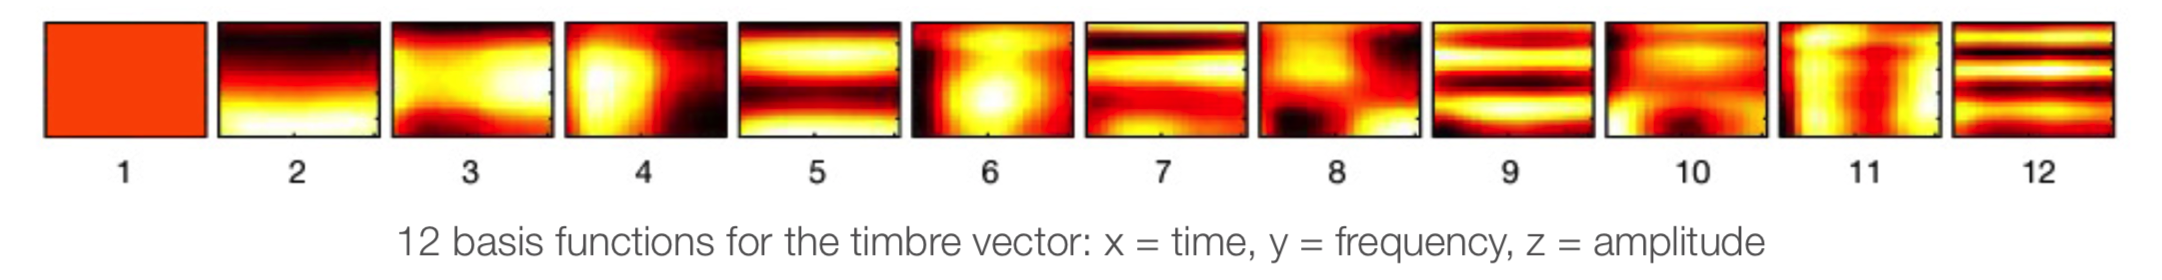

Lo mismo con los descriptores de nota (pitch)

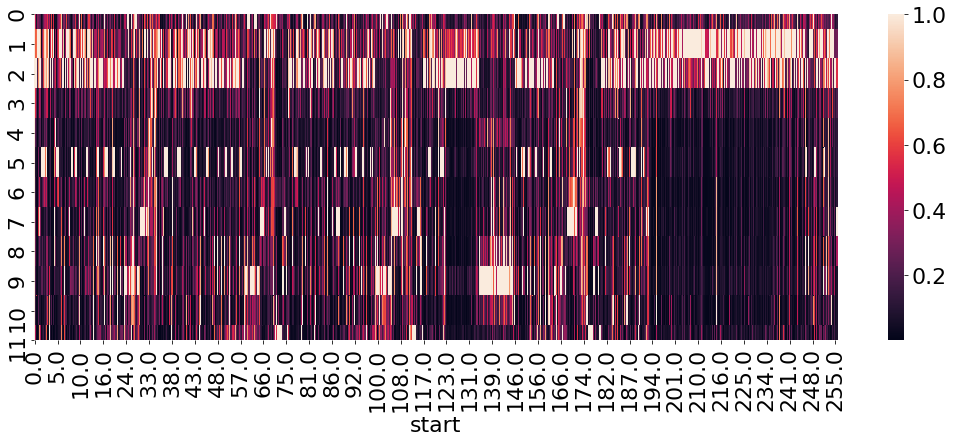

In [25]:
pitches = pd.DataFrame(np.vstack(segments.pitches), index=segments.start.round())
plt.figure(figsize=(18,6))
sns.heatmap(pitches.T);

Diagrama de como se computa la distribución de notas según Spotify
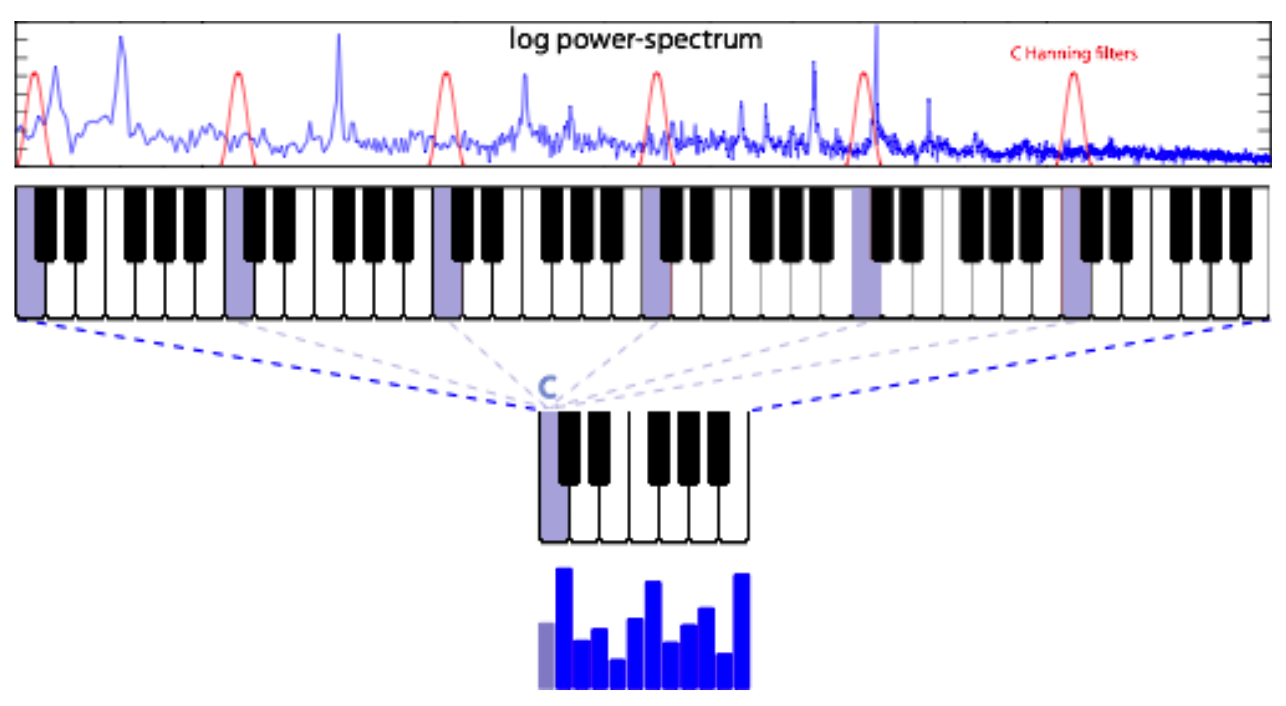

# Descriptores de muchos tracks

Busquemos con sp.search y pidamos 40 resultados de dos bandas

In [71]:
artist = 'the beatles'
search =  sp.search(artist,limit=40)
df_tracks_ = pd.DataFrame(search['tracks']['items'])
df_tracks_['artist_name'] = artist

artist = 'mona jimenez'
search =  sp.search(artist,limit=40)
df_tracks = pd.DataFrame(search['tracks']['items'])
df_tracks['artist_name'] = artist

df_tracks = pd.concat([df_tracks_,df_tracks]).reset_index()

Luego usamos los ids para pedir los descriptores

In [72]:
df_features = pd.DataFrame(sp.audio_features(df_tracks['id']))
df_features

,acousticness,analysis_url,danceability,duration_ms,energy,id,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,track_href,type,uri,valence
0,0.03390,https://api.spotify.com/v1/audio-analysis/6dGn...,0.557,185733,0.540,6dGnYIeXmHdcikdzNNDMm2,0.002480,9,0.1790,-10.484,1,0.0347,129.171,4,https://api.spotify.com/v1/tracks/6dGnYIeXmHdc...,audio_features,spotify:track:6dGnYIeXmHdcikdzNNDMm2,0.394
1,0.03020,https://api.spotify.com/v1/audio-analysis/2Eql...,0.533,259947,0.376,2EqlS6tkEnglzr7tkKAAYD,0.248000,9,0.0926,-11.913,0,0.0393,165.007,4,https://api.spotify.com/v1/tracks/2EqlS6tkEngl...,audio_features,spotify:track:2EqlS6tkEnglzr7tkKAAYD,0.187
2,0.01120,https://api.spotify.com/v1/audio-analysis/0aym...,0.386,425653,0.607,0aym2LBJBk9DAYuHHutrIl,0.000014,10,0.0880,-7.700,1,0.0261,147.207,4,https://api.spotify.com/v1/tracks/0aym2LBJBk9D...,audio_features,spotify:track:0aym2LBJBk9DAYuHHutrIl,0.532
3,0.63100,https://api.spotify.com/v1/audio-analysis/7iN1...,0.443,243027,0.403,7iN1s7xHE4ifF5povM6A48,0.000000,0,0.1110,-8.339,1,0.0322,143.462,4,https://api.spotify.com/v1/tracks/7iN1s7xHE4if...,audio_features,spotify:track:7iN1s7xHE4ifF5povM6A48,0.410
4,0.87900,https://api.spotify.com/v1/audio-analysis/3BQH...,0.332,125667,0.179,3BQHpFgAp4l80e1XslIjNI,0.000000,5,0.0886,-11.830,1,0.0326,96.529,4,https://api.spotify.com/v1/tracks/3BQHpFgAp4l8...,audio_features,spotify:track:3BQHpFgAp4l80e1XslIjNI,0.315
5,0.38600,https://api.spotify.com/v1/audio-analysis/4pbG...,0.490,145747,0.715,4pbG9SUmWIvsROVLF0zF9s,0.000000,7,0.3110,-5.549,1,0.0476,130.726,4,https://api.spotify.com/v1/tracks/4pbG9SUmWIvs...,audio_features,spotify:track:4pbG9SUmWIvsROVLF0zF9s,0.866
6,0.64100,https://api.spotify.com/v1/audio-analysis/5ZBe...,0.482,155227,0.849,5ZBeML7Lf3FMEVviTyvi8l,0.000008,2,0.0414,-9.198,1,0.0452,124.631,4,https://api.spotify.com/v1/tracks/5ZBeML7Lf3FM...,audio_features,spotify:track:5ZBeML7Lf3FMEVviTyvi8l,0.937
7,0.44900,https://api.spotify.com/v1/audio-analysis/3Kfb...,0.688,146333,0.435,3KfbEIOC7YIv90FIfNSZpo,0.000000,9,0.1130,-11.359,1,0.0323,103.239,4,https://api.spotify.com/v1/tracks/3KfbEIOC7YIv...,audio_features,spotify:track:3KfbEIOC7YIv90FIfNSZpo,0.435
8,0.75400,https://api.spotify.com/v1/audio-analysis/5jgF...,0.686,138387,0.127,5jgFfDIR6FR0gvlA56Nakr,0.000014,7,0.0573,-14.361,1,0.0342,93.699,4,https://api.spotify.com/v1/tracks/5jgFfDIR6FR0...,audio_features,spotify:track:5jgFfDIR6FR0gvlA56Nakr,0.372
9,0.19800,https://api.spotify.com/v1/audio-analysis/0pNe...,0.396,182293,0.338,0pNeVovbiZHkulpGeOx1Gj,0.000003,0,0.1380,-10.872,1,0.0304,133.522,4,https://api.spotify.com/v1/tracks/0pNeVovbiZHk...,audio_features,spotify:track:0pNeVovbiZHkulpGeOx1Gj,0.377


Seleccionamos algunas columnas

In [76]:
af = df_features[['danceability','energy','loudness','speechiness','acousticness','instrumentalness','valence','tempo','liveness','key','mode','time_signature']]
af

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,valence,tempo,liveness,key,mode,time_signature
0,0.557,0.540,-10.484,0.0347,0.03390,0.002480,0.394,129.171,0.1790,9,1,4
1,0.533,0.376,-11.913,0.0393,0.03020,0.248000,0.187,165.007,0.0926,9,0,4
2,0.386,0.607,-7.700,0.0261,0.01120,0.000014,0.532,147.207,0.0880,10,1,4
3,0.443,0.403,-8.339,0.0322,0.63100,0.000000,0.410,143.462,0.1110,0,1,4
4,0.332,0.179,-11.830,0.0326,0.87900,0.000000,0.315,96.529,0.0886,5,1,4
5,0.490,0.715,-5.549,0.0476,0.38600,0.000000,0.866,130.726,0.3110,7,1,4
6,0.482,0.849,-9.198,0.0452,0.64100,0.000008,0.937,124.631,0.0414,2,1,4
7,0.688,0.435,-11.359,0.0323,0.44900,0.000000,0.435,103.239,0.1130,9,1,4
8,0.686,0.127,-14.361,0.0342,0.75400,0.000014,0.372,93.699,0.0573,7,1,4
9,0.396,0.338,-10.872,0.0304,0.19800,0.000003,0.377,133.522,0.1380,0,1,4


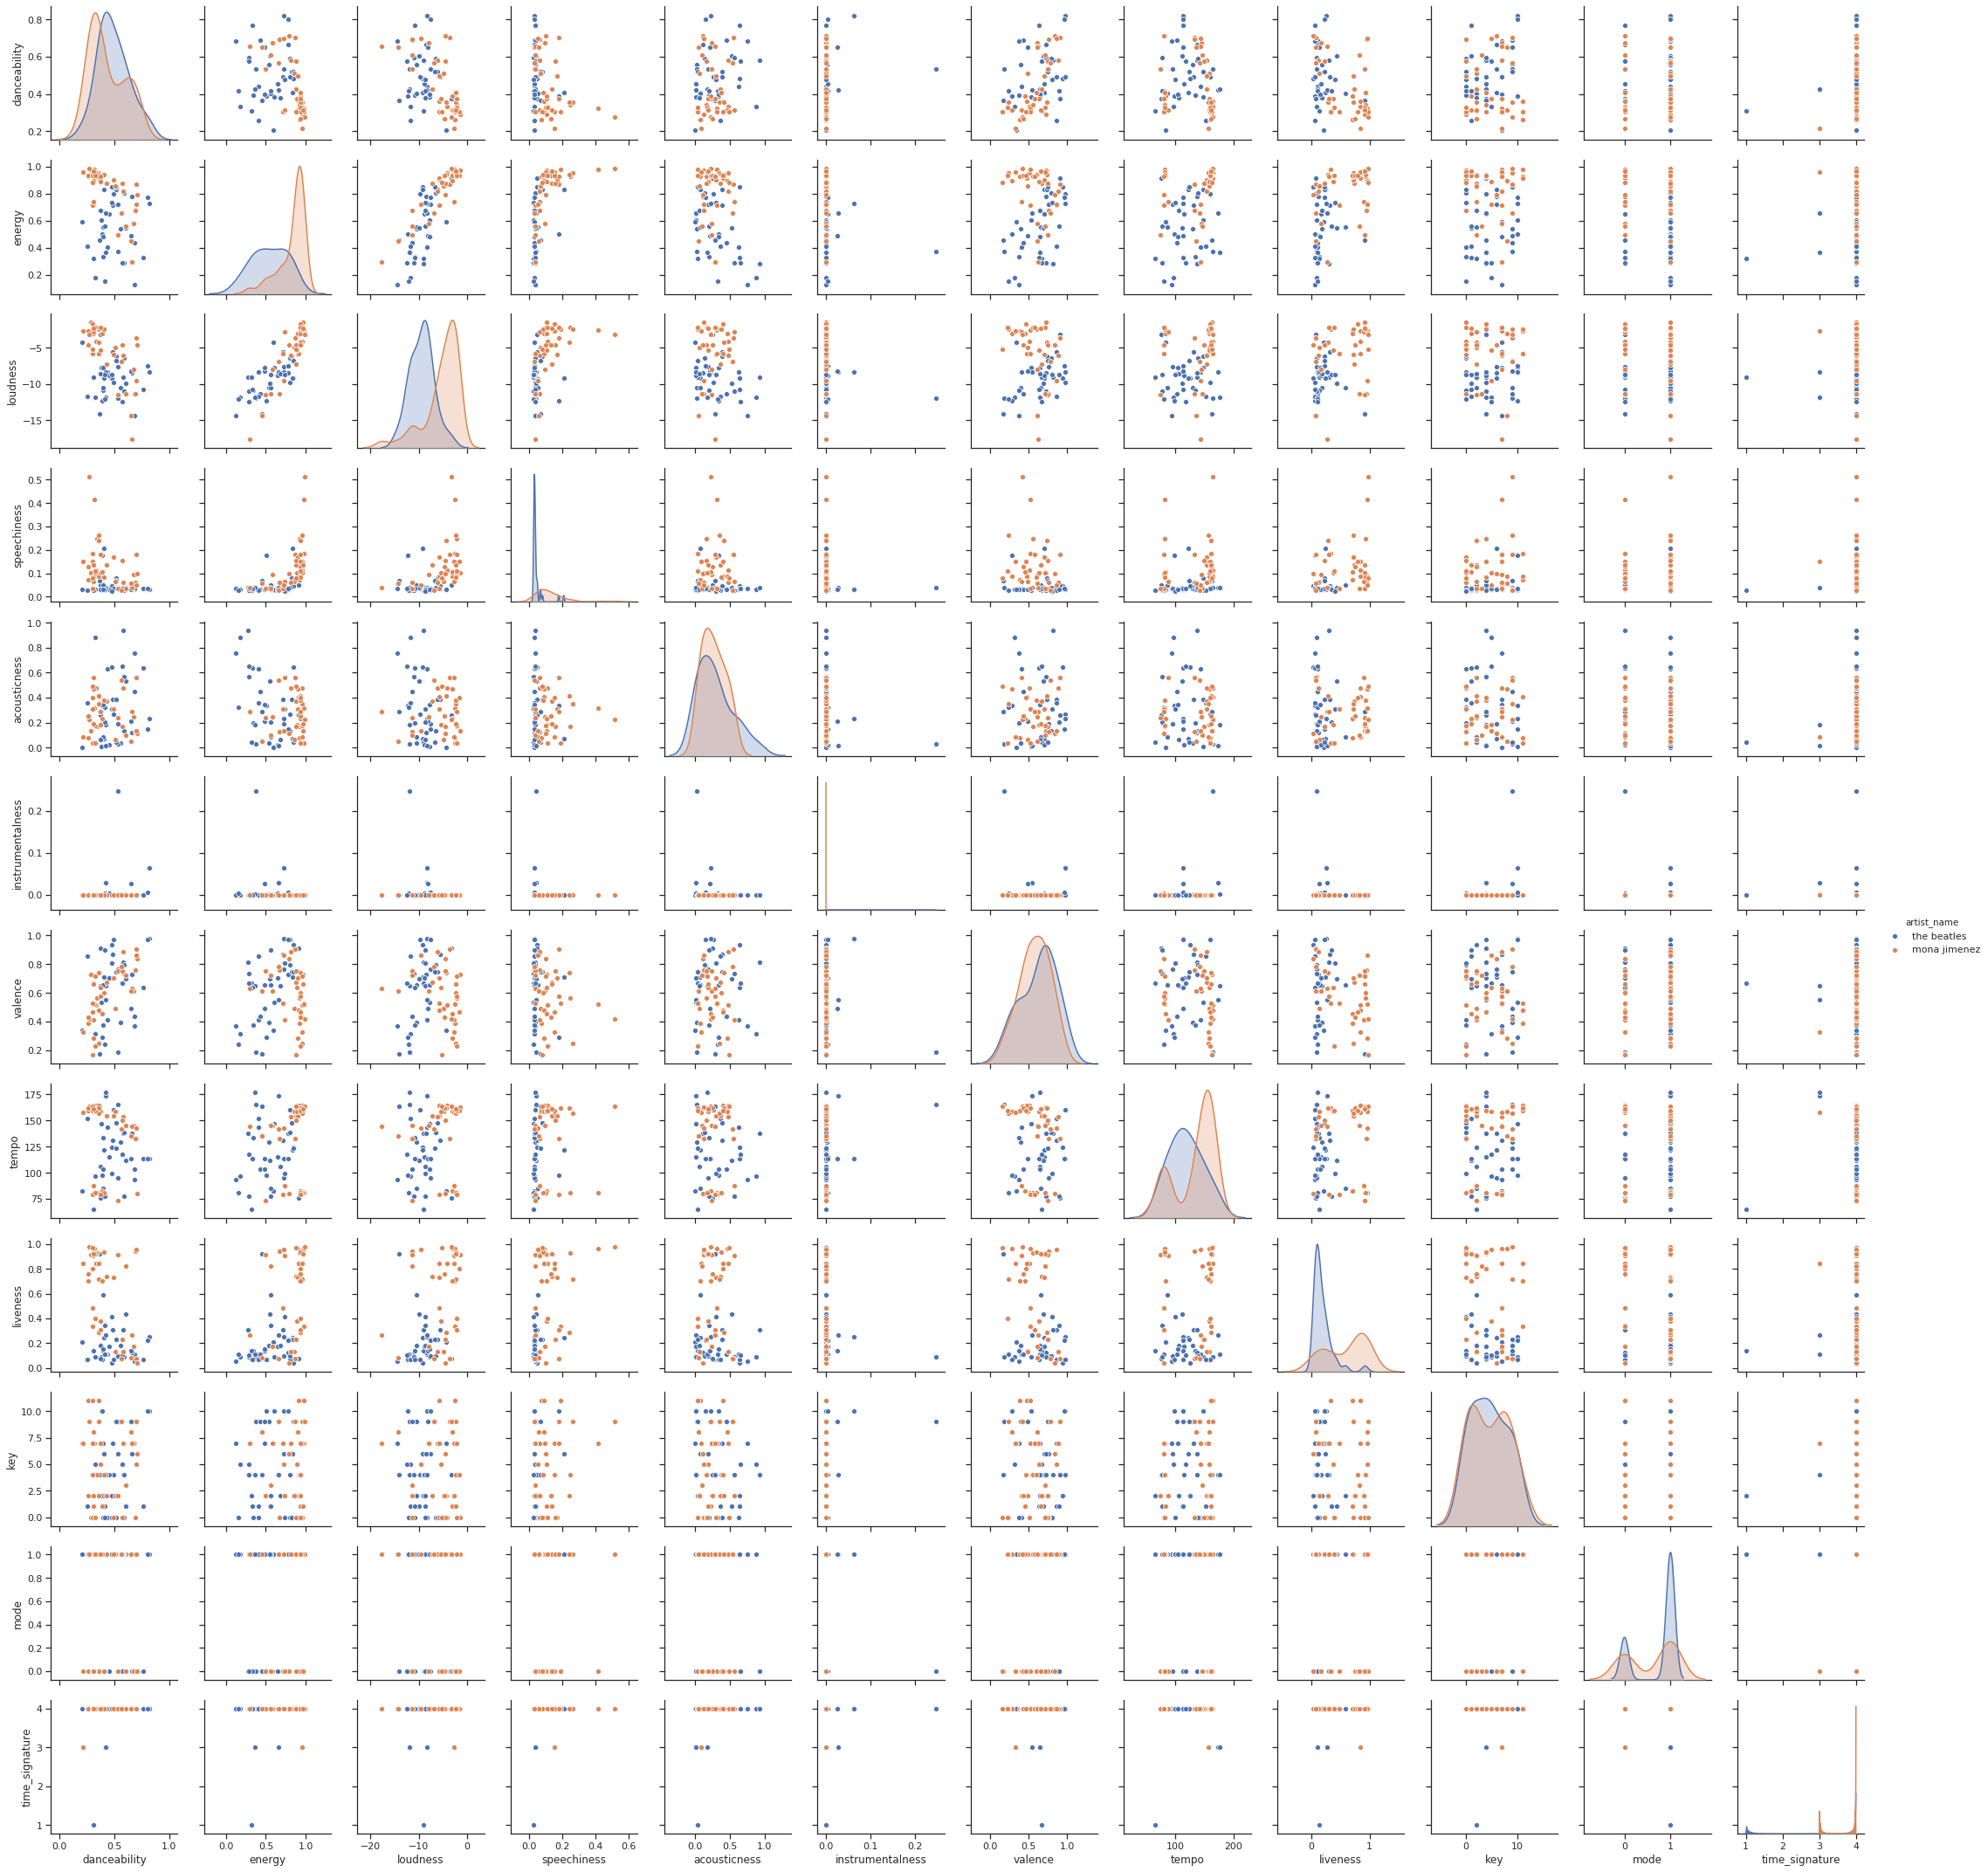

In [77]:
sns.set(style="ticks")
sns.pairplot(pd.concat([af,df_tracks.artist_name],axis=1),hue='artist_name');

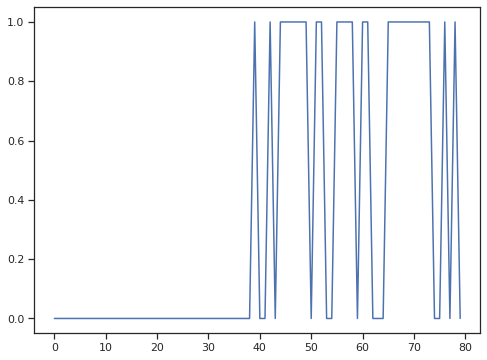

In [81]:

ss = StandardScaler()
af_norm = ss.fit_transform(af)

km = KMeans(n_clusters=2)
km.fit(af_norm)
# adjusted_rand_score(df_meta.artist_name,km.labels_)
plt.plot(km.labels_)